In [2]:
# Libraries 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model


Get the Data 

In [3]:
# Load Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Create dictionaries to store the datasets
train_hozana = {'images': train_images[:60000], 'labels': train_labels[:60000]}
test_hozana = {'images': test_images[:10000], 'labels': test_labels[:10000]}

print(train_hozana['images'].shape)
print(train_hozana['labels'].shape)
print(test_hozana['images'].shape)
print(test_hozana['labels'].shape)


(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


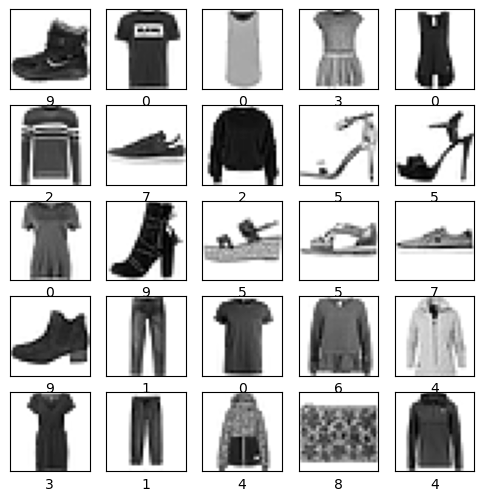

In [4]:
# Visualize sample images
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_hozana['images'][i], cmap=plt.cm.binary)
    plt.xlabel(train_hozana['labels'][i])
plt.show()

In [5]:
# Class Distribution
unique_train_labels, train_labels_counts = np.unique(train_hozana['labels'], return_counts=True)
unique_test_labels, test_labels_counts = np.unique(test_hozana['labels'], return_counts=True)

print("Training Set Class Distribution:")
print(dict(zip(unique_train_labels, train_labels_counts)))

print("\nTesting Set Class Distribution:")
print(dict(zip(unique_test_labels, test_labels_counts)))

Training Set Class Distribution:
{0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}

Testing Set Class Distribution:
{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


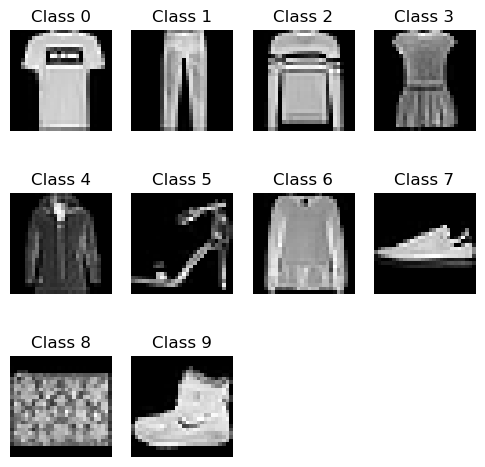

In [6]:
# Sample Class Images
plt.figure(figsize=(6, 6))
for i in range(10):
    plt.subplot(3, 4, i + 1)
    label = train_hozana['labels'] == i
    plt.imshow(train_hozana['images'][np.argmax(label)], cmap='gray')
    plt.title(f'Class {i}')
    plt.axis('off')
plt.show()

Data Processing 

In [7]:
# Normalizing pixel values
train_hozana['images'] = train_hozana['images'] / 255.0
test_hozana['images'] = test_hozana['images'] / 255.0

print(train_hozana['images'].shape)
print(test_hozana['images'].shape)


(60000, 28, 28)
(10000, 28, 28)


Build Variational Autoencoder

In [8]:
class SampleLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        
        # Calculate batch size and dimension of the input
        batch_size = tf.shape(mean)[0]
        latent_dim = tf.shape(mean)[1]
        
        # Generate random noise from standard normal distribution
        epsilon = tf.keras.backend.random_normal(shape=(batch_size, latent_dim))
        
        # Sample from the latent space using reparameterization trick
        sampled_z = mean + tf.exp(0.5 * log_var) * epsilon
        
        return sampled_z


Model Arquitecture 1

In [9]:

# Define input layer
input_img = Input(shape=(28, 28, 1))

# Layer 1
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
# Layer 2
x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
# Layer 3
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# Layer 4
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# Layer 5
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
# Latent Space A
z_mu_hozana = Dense(2, name='z_mu_hozana')(x)
# Latent Space B
z_log_sigma_hozana = Dense(2, name='z_log_sigma_hozana')(x)


# Define the encoder model
encoder_model = Model(input_img, [z_mu_hozana, z_log_sigma_hozana], name='encoder')


In [10]:
# Display summary of the encoder model
encoder_model.summary()



Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 14, 14, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 14, 14, 64)           36928     ['conv2d_1[0][0]']            
                                                                                            

In [11]:

# Plot a diagram illustrating the structure of the model
plot_model(encoder_model, show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Model Arquitecture 2

In [12]:
# Define input layer for the latent dimension
latent_input = Input(shape=(2,))

# Layer 1
x = Dense(12544, activation='relu')(latent_input) 
# Layer 2
x = Reshape((14, 14, 64))(x) 
# Layer 3
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
# Layer 4
decoded_output = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

# Define the decoder model
decoder_hozana = Model(latent_input, decoded_output, name='decoder')


In [13]:
decoder_hozana.summary()

# Plot a diagram
plot_model(decoder_hozana, to_file='decoder_model.png', show_shapes=True, show_layer_names=True)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 12544)             37632     
                                                                 
 reshape (Reshape)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 28, 28, 32)        18464     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 1)         289       
 Transpose)                                                      
                                                                 
Total params: 56385 (220.25 KB)
Trainable params: 56385 (22

Model Arquitecture 3

In [14]:
# Define input layer for the encoder
encoder_input = Input(shape=(28, 28, 1))

# Obtain the mean and log variance from the encoder
z_mu_hozana, z_log_sigma_hozana = encoder_model(encoder_input)

# Use the SampleLayer to sample from the latent space
z_hozana = SampleLayer()([z_mu_hozana, z_log_sigma_hozana])

# Define the output of the decoder
decoded_output = decoder_hozana(z_hozana)

# Define the VAE model with encoder input and decoder output
vae_hozana = Model(encoder_input, decoded_output, name='vae')


In [15]:

vae_hozana.summary()

# Plot a diagram illustrating the structure of the model
plot_model(vae_hozana, to_file='vae_model.png', show_shapes=True, show_layer_names=True)

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  494244    ['input_3[0][0]']             
                              (None, 2)]                                                          
                                                                                                  
 sample_layer (SampleLayer)  (None, 2)                    0         ['encoder[0][0]',             
                                                                     'encoder[0][1]']             
                                                                                                

In [16]:
# Define KL divergence loss
kl_loss = -0.5 * tf.reduce_mean(z_mu_hozana - tf.square(z_mu_hozana) - tf.exp(z_log_sigma_hozana) + 1)


In [17]:
# Add KL loss to VAE model
vae_hozana.add_loss(kl_loss)


In [18]:
# Compile the model
vae_hozana.compile(optimizer='adam', loss='mean_squared_error')


Train the Model

In [19]:
# Define the number of epochs and batch size
epochs = 5
batch_size = 156

# Train the VAE model
history = vae_hozana.fit(train_hozana['images'], train_hozana['images'],
                             epochs=epochs,
                             batch_size=batch_size)


Epoch 1/5

190/385 [=============>................] - ETA: 10:10 - loss: -0.5152

313/313 [==============================] - 5s 15ms/step


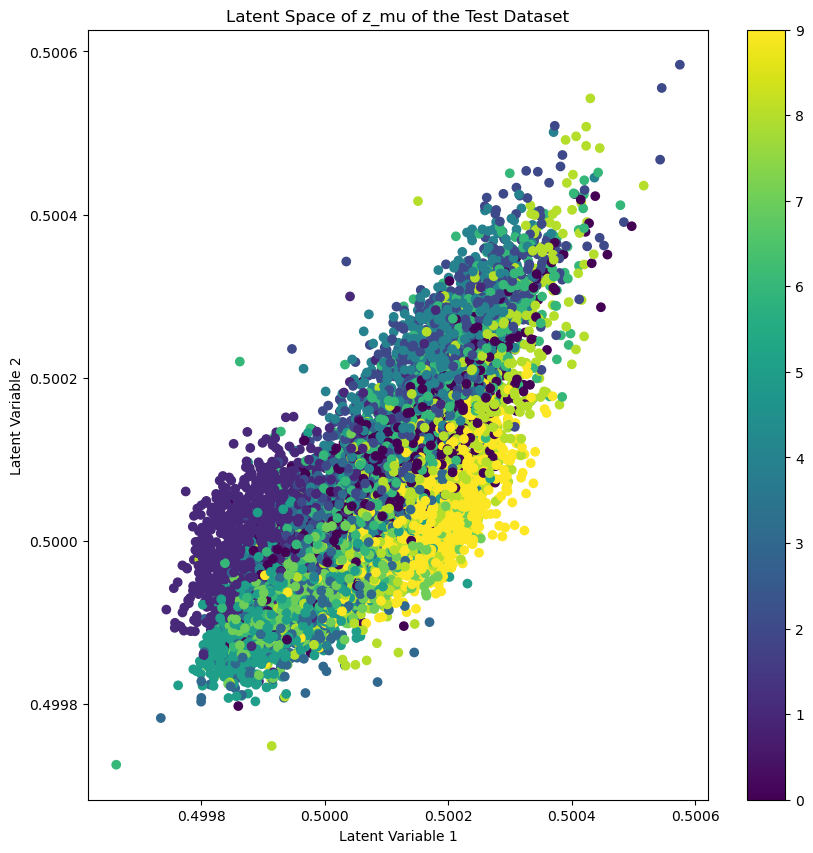

In [ ]:

# Define a function to generate latent space from z_mu
latent_space_model = Model(encoder_input, z_mu_hozana)

# Predict the encoded latent space of the test dataset
encoded_latent_space = latent_space_model.predict(test_hozana['images'])

# Plot the latent space using matplotlib.pyplot.scatter
plt.figure(figsize=(10, 10))
plt.scatter(encoded_latent_space[:, 0], encoded_latent_space[:, 1], c=test_hozana['labels'], cmap='viridis')
plt.colorbar()
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.title('Latent Space of z_mu of the Test Dataset')
plt.show()


313/313 [==============================] - 7s 21ms/step


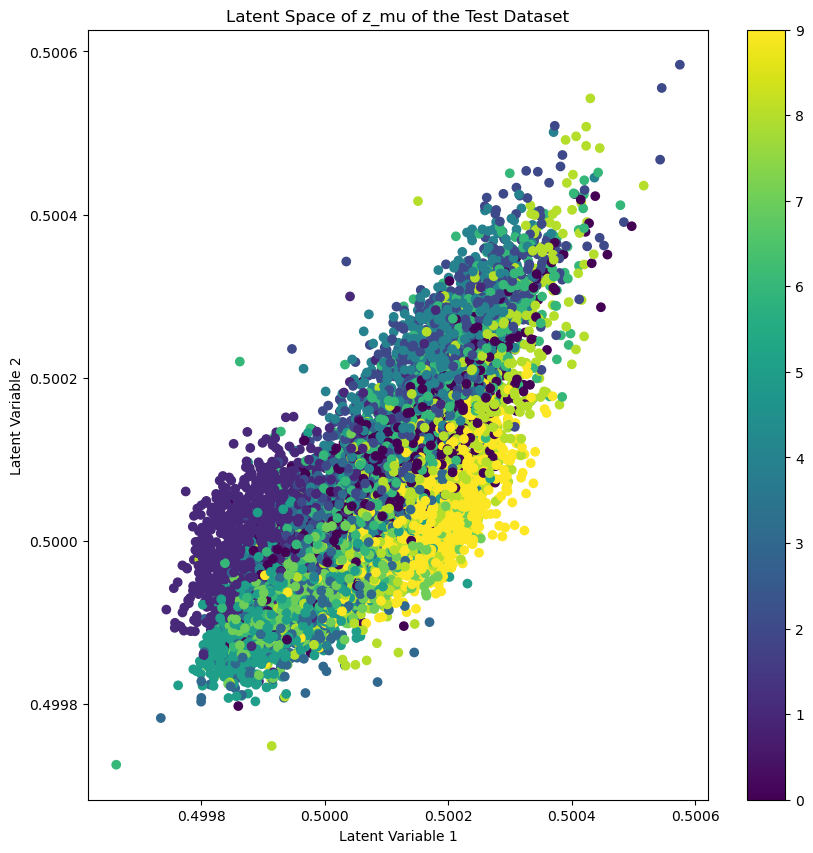

In [ ]:
# Build a model to generate the latent space for z_mu
latent_space_model = Model(encoder_input, z_mu_hozana)

# Predict the encoded latent space of the test dataset
encoded_latent_space = latent_space_model.predict(test_hozana['images'])

# Plot the latent space using matplotlib.pyplot.scatter
plt.figure(figsize=(10, 10))
plt.scatter(encoded_latent_space[:, 0], encoded_latent_space[:, 1], c=test_hozana['labels'], cmap='viridis')
plt.colorbar()
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.title('Latent Space of z_mu of the Test Dataset')
plt.show()
